In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

# pytorch computational graph
from torchviz import make_dot

# Set the seed for PyTorch
torch_seed = 42
torch.manual_seed(torch_seed)

# Determine if a GPU is available
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available compute device for training: {compute_device}")

Available compute device for training: cuda


# Load and Normalize Data

Normalization values of 0.1307 and 0.3081 are commonly used for the MNIST dataset.

In [2]:
# Create transform object to aid in normalization of incoming data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Split into training and testing datasets
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = len(train_data)
print ('train_size', train_size)

test_size = len(test_data)
print ('test_size', test_size)

# Collate function to move data to GPU
def collate_fn(batch):
    if torch.cuda.is_available():
        inputs, targets = zip(*batch)
        inputs = torch.stack(inputs).to(compute_device)
        targets = torch.tensor(targets).to(compute_device)
        return inputs, targets

# train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
# test_loader = DataLoader(test_data,batch_size=1, shuffle=False)
test_loader = DataLoader(test_data,batch_size=1, shuffle=False, collate_fn=collate_fn)

train_size 60000
test_size 10000


In [3]:
# # test if data is on GPU
# for batch in train_loader:
#     for tensor in batch:
#         if tensor.is_cuda:
#             print('data is on GPU')
#         else:
#             print('data is on CPU')

# Visualize Data

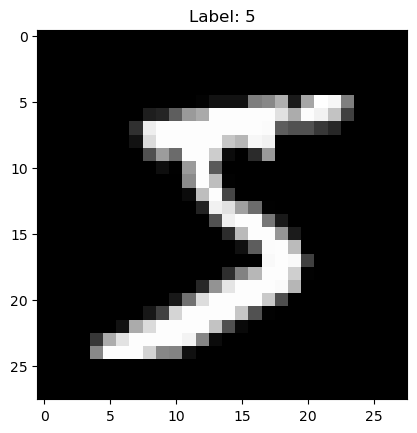

In [4]:
for images, labels in train_loader:
    # Visualize the first image in the batch
    plt.imshow(images[0].cpu().squeeze(), cmap='gray')
    plt.title(f"Label: {labels[0]}")
    plt.show()
    break  # Break after visualizing the first image in the batch

# Define the Convolutional Neural Network

In [5]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # Input channels (1 for grayscale), output channels (6 filters), kernel size 5
        self.pool = nn.MaxPool2d(2, 2)  # Kernel size 2, stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjust based on input size after conv2.
        # Pooling layer is also applied after the 2nd Conv Layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output: 10 class probabilities (0-9)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))# Pooling layer is also applied after the 2nd Conv Layer
        x = x.view(-1, 16 * 4 * 4)  # Flatten for FC layers, The -1 in the first dimension means it will preserve the batch size
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # Logits will get returned

        return x

# Instantiate the Model

Define the loss function and optimizer.

In [6]:
model = MNISTClassifier().to(compute_device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the Model

In [7]:
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        # Print statistics
        running_loss += loss.item()


        if (i==937):
            print('[%d] loss: %.3f' % (epoch + 1, running_loss/938))
            running_loss = 0.0


[1] loss: 0.244
[2] loss: 0.075
[3] loss: 0.053
[4] loss: 0.041
[5] loss: 0.032
[6] loss: 0.027
[7] loss: 0.024
[8] loss: 0.020
[9] loss: 0.019
[10] loss: 0.017


# Calculate Loss for Testing Data

In [8]:
running_loss = 0.0
concatenated_outputs = []

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    with torch.no_grad():
        outputs = model(inputs)
        concatenated_outputs.append(outputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

# Print statistics
print('[%d] loss: %.3f' % (i + 1, running_loss / 10000))

final_output = torch.cat(concatenated_outputs, dim=0)
print ('final_output shape', final_output.shape)

[10000] loss: 0.046
final_output shape torch.Size([10000, 10])


# Test the Trained Convolutional Neural Network Using Random Data Samples

Random indices: [4185, 5874, 8684]

Image at index 4185 - Predicted Label: 1


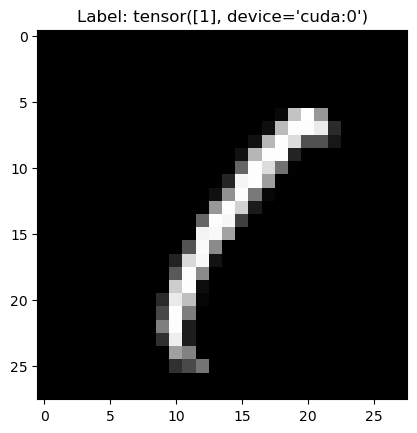

Image at index 5874 - Predicted Label: 5


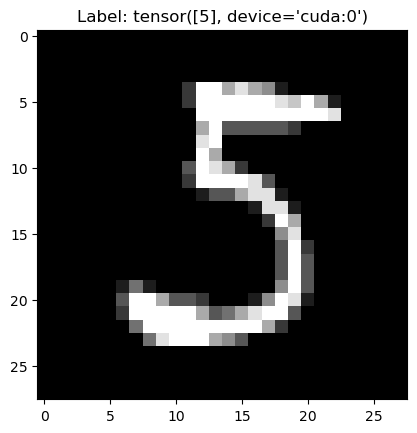

Image at index 8684 - Predicted Label: 3


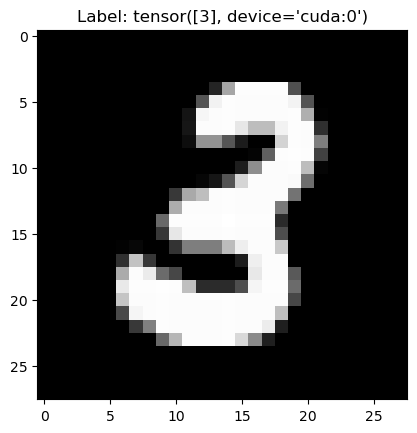

In [9]:
random.seed(5)

# Randomly choose three images
random_indices = random.sample(range(len(test_loader)), 3)
print(f'Random indices: {random_indices}\n')

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    for j in random_indices:
        if i == j:
            # Obtain predicted class probabilities for the image
            image_data = inputs
            label = labels

            logits_prediction = final_output[i]
            prediction_prob = torch.nn.functional.softmax(logits_prediction, dim=0)

            prediction = torch.argmax(prediction_prob)
            print(f"Image at index {i} - Predicted Label: {prediction}")
            plt.imshow(image_data.cpu().squeeze(), cmap='gray')
            plt.title(f"Label: {label}")
            plt.show()